# Using `load_ard` to load and cloud mask multiple satellite sensors

**Notebook currently compatible with both `NCI` and `DEA Sandbox` environments**

### Description
This notebook demonstrates how to use the `load_ard` function to import a time series of cloud-free observations from either multiple Landsat (i.e. Landsat 5, 7 and 8) or Sentinel 2 satellites (i.e. S2A and S2B). The function automatically applies cloud masking to the input data, and returns all available data from multiple sensors as a single combined `xarray.Dataset`.

Optionally, the function can be used to return only observations that contain a minimum proportion of good quality, non-cloudy or shadowed pixels. This can be used to extract visually appealing time series of observations that are not affected by cloud.

This notebook demonstrates how to use `load_ard` to:
* Load and combine Landsat 5, 7 and 8 data into a single `xarray.Dataset`
* Optionally apply a cloud mask to the resulting data
* Filter resulting data to keep only cloud-free observations
* Load and combine Sentinel 2A and 2B data into a single `xarray.Dataset`
* Optionally label resulting data with metadata indicating the satellite sensor the data came from


### Technical details
* **Products used:** 
[`ga_ls5t_ard_3`](https://explorer.sandbox.dea.ga.gov.au/ga_ls5t_ard_3/1990), 
[`ga_ls7e_ard_3`](https://explorer.sandbox.dea.ga.gov.au/ga_ls7e_ard_3/2000), 
[`ga_ls8c_ard_3`](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3/2016),
[`s2a_ard_granule`](https://explorer.sandbox.dea.ga.gov.au/s2a_ard_granule), 
[`s2b_ard_granule`](https://explorer.sandbox.dea.ga.gov.au/s2b_ard_granule)
* **Analyses used:** concatenating sensors, cloud masking, cloud filtering, extracting time series data

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

In [4]:
import datacube
datacube.__version__

'1.7+128.gebdc898a.dirty'

In [340]:
from owslib.wfs import WebFeatureService

# URL for WFS backend
url = "https://geoservice.maris.nl/wms/project/eyeonwater_australia?service=WFS&request=getcapabilities"

# See details about this particular WFS
# -------------------------------------

# Initialize
wfs = WebFeatureService(url=url)

# Service provider 
print(wfs.identification.title)

# Get WFS version
print(wfs.version)

# Available methods
print([operation.name for operation in wfs.operations])

# Available data layers
print(list(wfs.contents))

# Print all metadata of all layers
for layer, meta in wfs.items():
    print(meta.__dict__)
    
    


None
1.0.0
['GetCapabilities', 'DescribeFeatureType', 'GetFeature', 'Transaction', 'LockFeature', 'GetFeatureWithLock']
['EyeOnWater:eow_australia', 'EyeOnWater:eow_waterlab']
{'id': 'EyeOnWater:eow_australia', 'title': 'eow_australia', 'abstract': None, 'keywords': ['features, v_apk_photos_australia'], 'boundingBox': (-180.0, -90.0, 180.0, 90.0, urn:ogc:def:crs:EPSG::4326), 'boundingBoxWGS84': (-180.0, -90.0, 180.0, 90.0), 'crsOptions': [urn:ogc:def:crs:EPSG::4326], 'verbOptions': ['{http://www.opengis.net/wfs}Query', '{http://www.opengis.net/wfs}Insert', '{http://www.opengis.net/wfs}Update', '{http://www.opengis.net/wfs}Delete', '{http://www.opengis.net/wfs}Lock'], 'styles': None, 'timepositions': None, 'defaulttimeposition': None, 'metadataUrls': []}
{'id': 'EyeOnWater:eow_waterlab', 'title': 'eow_waterlab', 'abstract': None, 'keywords': ['features, eow_waterlab'], 'boundingBox': (-180.0, -90.0, 180.0, 90.0, urn:ogc:def:crs:EPSG::404000), 'boundingBoxWGS84': None, 'crsOptions': [urn

/usr/local/lib/python3.6/dist-packages/owslib/util.py:541: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if elements:


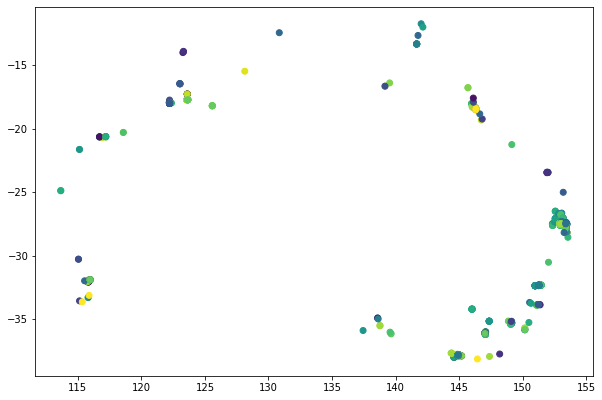

In [23]:
import geopandas as gpd
from requests import Request
from owslib.wfs import WebFeatureService

# Study area
xmin, xmax = 110, 160
ymax, ymin = 0, -40

# URL for WFS backend
url = f"https://geoservice.maris.nl/wms/project/eyeonwater_australia?service=WFS&request=getcapabilities&BBOX={xmin},{ymin},{xmax},{ymax}"

# Initialize
wfs = WebFeatureService(url=url)

# Fetch the last available layer 
layer = list(wfs.contents)[0]

# Specify the parameters for fetching the data
params = dict(service='WFS', 
              version="1.0.0", 
              request='GetFeature',
              typeName=layer, 
              outputFormat='json')

# Parse the URL with parameters
q = Request('GET', url, params=params).prepare().url

# Read data from URL
df = gpd.read_file(q)

# Convert to geodataframe
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lng, df.lat))

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, column ='fu_processed')

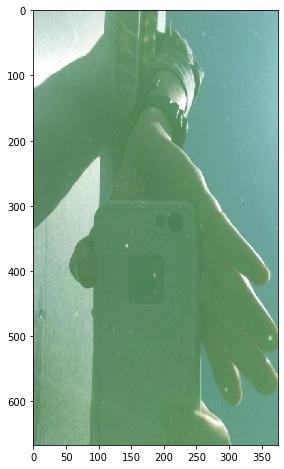

In [21]:
import matplotlib.pyplot as plt

# create a file-like object from the url
image_url = gdf.iloc[[99]]['image'].values.item()

plt.figure(figsize=(8, 8))
a = plt.imread(image_url)
plt.imshow(a)


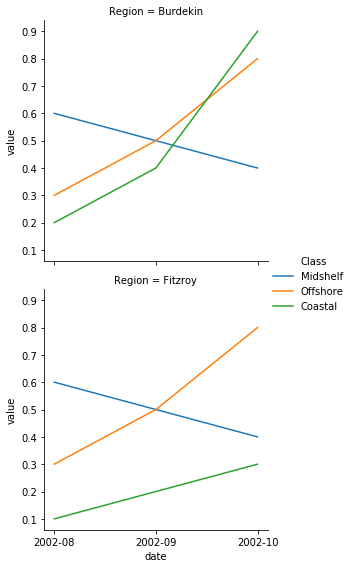

In [327]:
import seaborn as sns
import pandas as pd

# Create test data
pard_std_df = pd.DataFrame(data=[['Burdekin', 'Midshelf', 0.6, 0.5, 0.4],
                                 ['Burdekin', 'Offshore', 0.3, 0.5, 0.8],
                                 ['Burdekin', 'Coastal', 0.2, 0.4, 0.9],
                                 ['Fitzroy', 'Midshelf', 0.6, 0.5, 0.4],
                                 ['Fitzroy', 'Offshore', 0.3, 0.5, 0.8],
                                 ['Fitzroy', 'Coastal', 0.1, 0.2, 0.3]],
                           columns=['Region', 'Class', '2002-08', '2002-09', '2002-10'])

# 'Melt' the test data so we have a 'date' column and a 'value column'
pard_std_df_melted = pard_std_df.melt(id_vars=['Region', 'Class'], 
                                      var_name='date')

# Plot as a faceted plot
sns.relplot(data=pard_std_df_melted, 
            x='date', 
            y='value', 
            row='Region', 
            hue='Class', 
            kind='line', 
            height=4)


In [328]:
pard_std_df_melted

,Region,Class,date,value
0,Burdekin,Midshelf,2002-08,0.6
1,Burdekin,Offshore,2002-08,0.3
2,Burdekin,Coastal,2002-08,0.2
3,Fitzroy,Midshelf,2002-08,0.6
4,Fitzroy,Offshore,2002-08,0.3
5,Fitzroy,Coastal,2002-08,0.1
6,Burdekin,Midshelf,2002-09,0.5
7,Burdekin,Offshore,2002-09,0.5
8,Burdekin,Coastal,2002-09,0.4
9,Fitzroy,Midshelf,2002-09,0.5


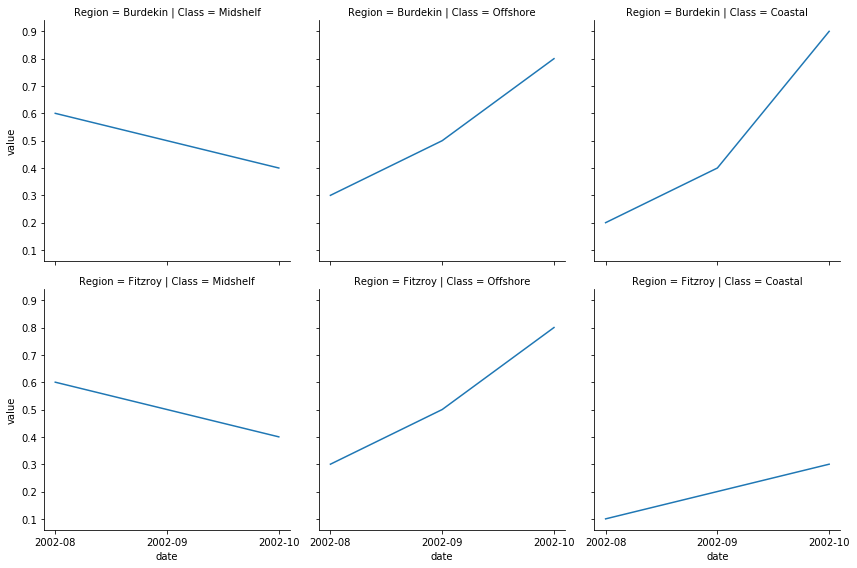

In [325]:
sns.relplot(data=pard_std_df_melted, 
            x='date', 
            y='value', 
            row='Region', 
            col='Class', 
            kind='line', 
            height=4)

In [316]:
pard_std_df_melted

,Region,Class,date,value
0,Burdekin,Midshelf,2002-08,0.6
1,Burdekin,Offshore,2002-08,0.3
2,Burdekin,Coastal,2002-08,0.2
3,Fitzroy,Midshelf,2002-08,0.6
4,Fitzroy,Offshore,2002-08,0.3
5,Fitzroy,Coastal,2002-08,0.1
6,Burdekin,Midshelf,2002-09,0.5
7,Burdekin,Offshore,2002-09,0.5
8,Burdekin,Coastal,2002-09,0.4
9,Fitzroy,Midshelf,2002-09,0.5


### Load packages


In [290]:
%matplotlib inline

import datacube
import sys

sys.path.append('../Scripts')
from dea_datahandling import load_ard
from dea_bandindices import calculate_indices
from dea_plotting import rgb
from dea_plotting import display_map

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [291]:
import datacube

# Temporary solution to connecting to datacube to account for 
# Collection 3 data being in a different database on the NCI
try:
    dc = datacube.Datacube(app='Collection_3', env='c3-samples')
except:
    dc = datacube.Datacube(app='Collection_3')

# Set up analysis data query. Compared to Collection 2, we need to 
# specify an 'output_crs' and 'resolution' (like Sentinel 2)
query = {'x': (142.20, 142.24),
         'y': (-32.45, -32.47),
         'time': ('2015-01-01', '2015-03-01'),
         'measurements': ['nbart_blue', 'nbart_red', 'nbart_green'],        
         'output_crs': 'EPSG:3577',
         'resolution': (-30, 30),
         }

# Load data
data = dc.load(product = 'ga_ls8c_ard_3', 
               group_by = 'solar_day', 
#                dask_chunks={'time': 1},
               **query)

print(data)

<xarray.Dataset>
Dimensions:      (time: 7, x: 131, y: 85)
Coordinates:
  * time         (time) datetime64[ns] 2015-01-06T00:20:26.943424 ... 2015-02-23T00:20:12.433781
  * y            (y) float64 -3.576e+06 -3.576e+06 ... -3.578e+06 -3.578e+06
  * x            (x) float64 9.501e+05 9.501e+05 ... 9.539e+05 9.54e+05
Data variables:
    nbart_blue   (time, y, x) int16 1145 1412 1448 1050 ... 994 995 1024 1183
    nbart_red    (time, y, x) int16 1499 1923 1958 1351 ... 1127 1109 1184 1297
    nbart_green  (time, y, x) int16 1678 2276 2250 1610 ... 1353 1327 1417 1527
Attributes:
    crs:      EPSG:3577


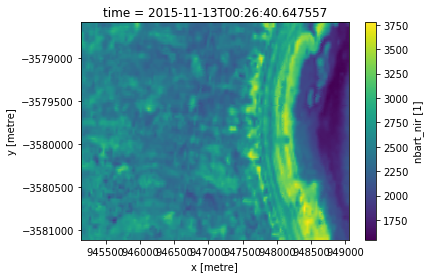

In [279]:
query = {'x': (142.15, 142.19),
         'y': (-32.48, -32.50),
         'time': ('2015-11-11', '2015-11-16'),  
         'output_crs': 'EPSG:3577',
         }

ls_ds = dc.load(product='ga_ls8c_ard_3', 
                measurements=['nbart_blue', 'nbart_red', 'nbart_nir', 'nbart_swir_2'],
                resolution=(-15, 15),
                group_by='solar_day',
                resampling='bilinear',
                **query)

ls_ds.nbart_nir.plot()

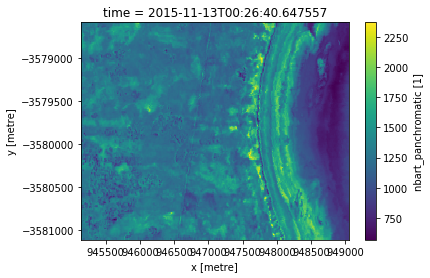

In [281]:
pan_ds = dc.load(product='ga_ls8c_ard_3', 
                measurements=['nbart_panchromatic'],
                resolution=(-15, 15),
                group_by='solar_day',
                **query)

pan_ds.nbart_panchromatic.plot()

In [155]:
# !pip install --user sklearn

In [156]:
import numpy as np

def hist_match(source, template):
    """
    Adjust the pixel values of a grayscale image such that its histogram matches that of a
    target image.
    Arguments:
    -----------
        source: np.array
            Image to transform; the histogram is computed over the flattened
            array
        template: np.array
            Template image; can have different dimensions to source
    Returns:
    -----------
        matched: np.array
            The transformed output image
    """

    oldshape = source.shape
    source = source.ravel()
    template = template.ravel()

    # get the set of unique pixel values and their corresponding indices and
    # counts
    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True,
                                            return_counts=True)
    t_values, t_counts = np.unique(template, return_counts=True)

    # take the cumsum of the counts and normalize by the number of pixels to
    # get the empirical cumulative distribution functions for the source and
    # template images (maps pixel value --> quantile)
    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]

    # interpolate linearly to find the pixel values in the template image
    # that correspond most closely to the quantiles in the source image
    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)

    return interp_t_values[bin_idx].reshape(oldshape)

In [282]:
import sklearn.decomposition as decomposition

im_ms = ls_ds.to_array().squeeze(dim='time').values.transpose([1, 2, 0])
im_pan = pan_ds.nbart_panchromatic.squeeze(dim='time').values  #.transpose([1, 2, 0])
cloud_mask = (im_pan > 100000)

# reshape image into vector and apply cloud mask
vec = im_ms.reshape(im_ms.shape[0] * im_ms.shape[1], im_ms.shape[2])
vec_mask = cloud_mask.reshape(im_ms.shape[0] * im_ms.shape[1])
vec = vec[~vec_mask, :]

# # apply PCA to multispectral bands
pca = decomposition.PCA()
vec_pcs = pca.fit_transform(vec)

# # replace 1st PC with pan band (after matching histograms)
vec_pan = im_pan.reshape(im_pan.shape[0] * im_pan.shape[1])
vec_pan = vec_pan[~vec_mask]
vec_pcs[:,0] = hist_match(vec_pan, vec_pcs[:,0])
vec_ms_ps = pca.inverse_transform(vec_pcs)

# # reshape vector into image
vec_ms_ps_full = np.ones((len(vec_mask), im_ms.shape[2])) * np.nan
vec_ms_ps_full[~vec_mask,:] = vec_ms_ps
im_ms_ps = vec_ms_ps_full.reshape(im_ms.shape[0], im_ms.shape[1], im_ms.shape[2])

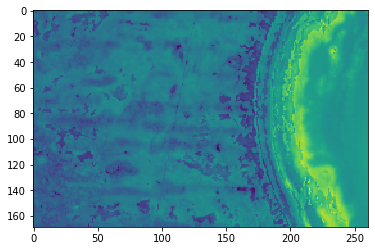

In [283]:
plt.imshow(im_ms_ps[:,:,0])

In [287]:
ls_ds['new'] = ls_ds.nbart_nir
ls_ds['new'].values = im_ms_ps.transpose([2, 0, 1])[[3],:,:]

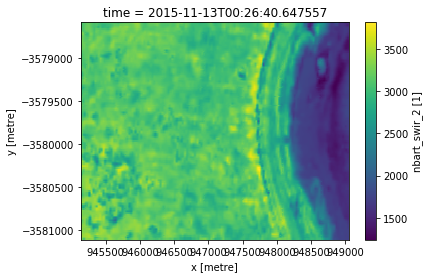

In [285]:
ls_ds['nbart_swir_2'].plot()

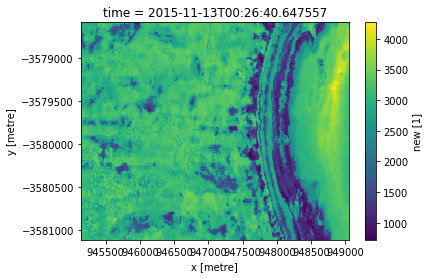

In [288]:
ls_ds['new'].plot()

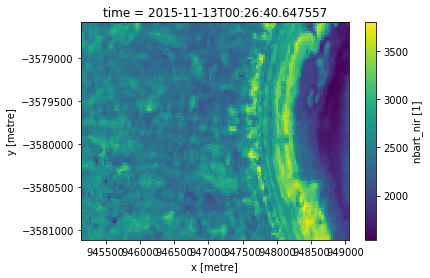

In [187]:
ls_ds['nbart_nir'].plot()

In [ ]:
# def pansharpen(im_ms, im_pan, cloud_mask):
#     """
#     Pansharpens a multispectral image, using the panchromatic band and a cloud mask.
#     A PCA is applied to the image, then the 1st PC is replaced with the panchromatic band.
#     Note that it is essential to match the histrograms of the 1st PC and the panchromatic band
#     before replacing and inverting the PCA.
#     KV WRL 2018
#     Arguments:
#     -----------
#         im_ms: np.array
#             Multispectral image to pansharpen (3D)
#         im_pan: np.array
#             Panchromatic band (2D)
#         cloud_mask: np.array
#             2D cloud mask with True where cloud pixels are
#     Returns:
#     -----------
#         im_ms_ps: np.ndarray
#             Pansharpened multispectral image (3D)
#     """

    # reshape image into vector and apply cloud mask
    vec = im_ms.reshape(im_ms.shape[0] * im_ms.shape[1], im_ms.shape[2])
    vec_mask = cloud_mask.reshape(im_ms.shape[0] * im_ms.shape[1])
    vec = vec[~vec_mask, :]


    # apply PCA to multispectral bands
    pca = decomposition.PCA()
    vec_pcs = pca.fit_transform(vec)

    # replace 1st PC with pan band (after matching histograms)
    vec_pan = im_pan.reshape(im_pan.shape[0] * im_pan.shape[1])
    vec_pan = vec_pan[~vec_mask]
    vec_pcs[:,0] = hist_match(vec_pan, vec_pcs[:,0])
    vec_ms_ps = pca.inverse_transform(vec_pcs)

    # reshape vector into image
    vec_ms_ps_full = np.ones((len(vec_mask), im_ms.shape[2])) * np.nan
    vec_ms_ps_full[~vec_mask,:] = vec_ms_ps
    im_ms_ps = vec_ms_ps_full.reshape(im_ms.shape[0], im_ms.shape[1], im_ms.shape[2])

    return im_ms_ps

In [26]:
ndvi = data.nbart_blue

In [21]:
ndvi_plot = ndvi.resample(time='1M', keep_attrs=True).median(dim='time', skipna=True) 
ndvi_plot['year'] = ('time', ndvi_plot.time.dt.year)
ndvi_plot['month'] = ('time', ndvi_plot.time.dt.month)
ndvi_plot = ndvi_plot.set_index(time=['month','year']).unstack('time')
ndvi_plot.plot(row='year', col='month', cmap='RdYlGn', vmin=0.1, vmax=0.8)

In [38]:
ndvi_plot = ndvi.resample(time='7D', keep_attrs=True).median(dim='time', skipna=True) 
# ndvi_plot['year'] = ('time', ndvi_plot.time.dt.year)
# ndvi_plot['week'] = ('time', ndvi_plot.time.dt.week)
# ndvi_plot = ndvi_plot.set_index(time=['week','year']).unstack('time')
# ndvi_plot.plot(row='year', col='week', cmap='RdYlGn', vmin=0.1, vmax=0.8)

In [46]:
ndvi_plot.time.dt.dayofyear

<xarray.DataArray 'dayofyear' (time: 59)>
array([ 13,  20,  27,  34,  41,  48,  55,  62,  69,  76,  83,  90,  97, 104,
       111, 118, 125, 132, 139, 146, 153, 160, 167, 174, 181, 188, 195, 202,
       209, 216, 223, 230, 237, 244, 251, 258, 265, 272, 279, 286, 293, 300,
       307, 314, 321, 328, 335, 342, 349, 356, 363,   5,  12,  19,  26,  33,
        40,  47,  54])
Coordinates:
  * time     (time) datetime64[ns] 1989-01-13 1989-01-20 ... 1990-02-23

In [ ]:
import numpy as np
data.astype(np.float32)

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

np.random.seed(123)

times = pd.date_range("2000-01-01", "2001-12-31", name="time")
annual_cycle = np.sin(2 * np.pi * (times.dayofyear.values / 365.25 - 0.28))

base = 10 + 15 * annual_cycle.reshape(-1, 1)
tmin_values = base + 3 * np.random.randn(annual_cycle.size, 3)
tmax_values = base + 10 + 3 * np.random.randn(annual_cycle.size, 3)

ds = xr.Dataset({"tmin": (("time", "location"), tmin_values),
                 "tmax": (("time", "location"), tmax_values),},
                {"time": times, "location": ["IA", "IN", "IL"]})

# Assign an attribute
ds = ds.assign_attrs(CRS = 'EPSG:4326')

# Change dtype
ds.astype(np.float32)

<xarray.Dataset>
Dimensions:   (location: 3, time: 731)
Coordinates:
  * location  (location) <U2 'IA' 'IN' 'IL'
  * time      (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2001-12-31
Data variables:
    tmin      (time, location) float32 -8.03737 -1.7884412 ... -4.543927
    tmax      (time, location) float32 12.980549 3.3104093 ... 3.8052793
Attributes:
    CRS:      EPSG:4326

In [13]:
ds.tmin.attrs['nodata']  = -999

### Connect to the datacube


In [ ]:
# Connect to datacube containg Sentinel 2 data
dc_sentinel2 = datacube.Datacube(app='Using_load_ard')

# Temporary solution to account for Collection 3 data being in a different
# database on the NCI
try:
    dc_landsat = datacube.Datacube(app='Using_load_ard', env='c3-samples')
except:
    dc_landsat = datacube.Datacube(app='Using_load_ard')


## Loading multiple Landsat sensors
The `load_ard` function can be used to load a single, combined timeseries of cloud-masked data from multiple `DEA` products or satellite sensors. 
At its simplest, you can use the function similarly to `dc.load`, by passing a set of spatiotemporal query parameters (e.g. `x`, `y`, `time`, `measurements`, `output_crs`, `resolution`, `group_by` etc) directly into the function ([see the `dc.load` documentation for all possible options](https://datacube-core.readthedocs.io/en/latest/dev/api/generate/datacube.Datacube.load.html)). 
The key difference from `dc.load` is that we also need to pass an existing `Datacube` object to the function using the `dc` parameter. 
This gives us flexibilty to load data from development or experimental datacubes.

In the example below, we load a single band of data (`nbart_green`) from the three Landsat Collection 3 products (Landsat 5, 7 and 8) by specifying: `products=['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3']`. 
You can see that the function loaded 0 Landsat 5 observations, 11 Landsat 7 observations, and 12 Landsat 8 observations into a simple combined dataset containg 23 observations:

In [ ]:
# Load available data from all three Landsat satellites
ds = load_ard(dc=dc_landsat,
              products=['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'],
              x=(153.38, 153.47),
              y=(-28.83, -28.92),
              time=('2018-01', '2018-06'),
              measurements=['nbart_green', 'nbart_blue', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2'],
              output_crs='EPSG:3577',
              resolution=(-30, 30),
              group_by='solar_day')

# Print output data
print(ds)


In [ ]:
import sys

sys.getsizeof(ds.nbart_green.values)

In [ ]:
import sys

sys.getsizeof(ds.nbart_green.values)

In [ ]:
# Load available data from all three Landsat satellites
ds = load_ard(dc=dc_sentinel2,
              products=['s2a_ard_granule', 's2a_ard_granule'],
              x=(153.38, 153.47),
              y=(-28.83, -28.92),
              time=('2018-01', '2018-06'),
              measurements=['nbart_red_edge_1', 'nbart_red'],
              output_crs='EPSG:3577',
              resolution=(-30, 30),
              group_by='solar_day')

# Print output data
print(ds)

In [ ]:
ds2 = calculate_indices(ds, 
                        index='NDCI', 
                        collection='ga_s2_1') 



In [ ]:
ds2

We can achieve the same result using the `query` syntax:

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** September 2019

**Compatible `datacube` version:** 

In [ ]:
print(datacube.__version__)

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)